In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import tensorflow as tf
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11509542714067010310
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12109260890814274893
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
2.10.1


angry
disgust
fear
happy
neutral
sad
surprise


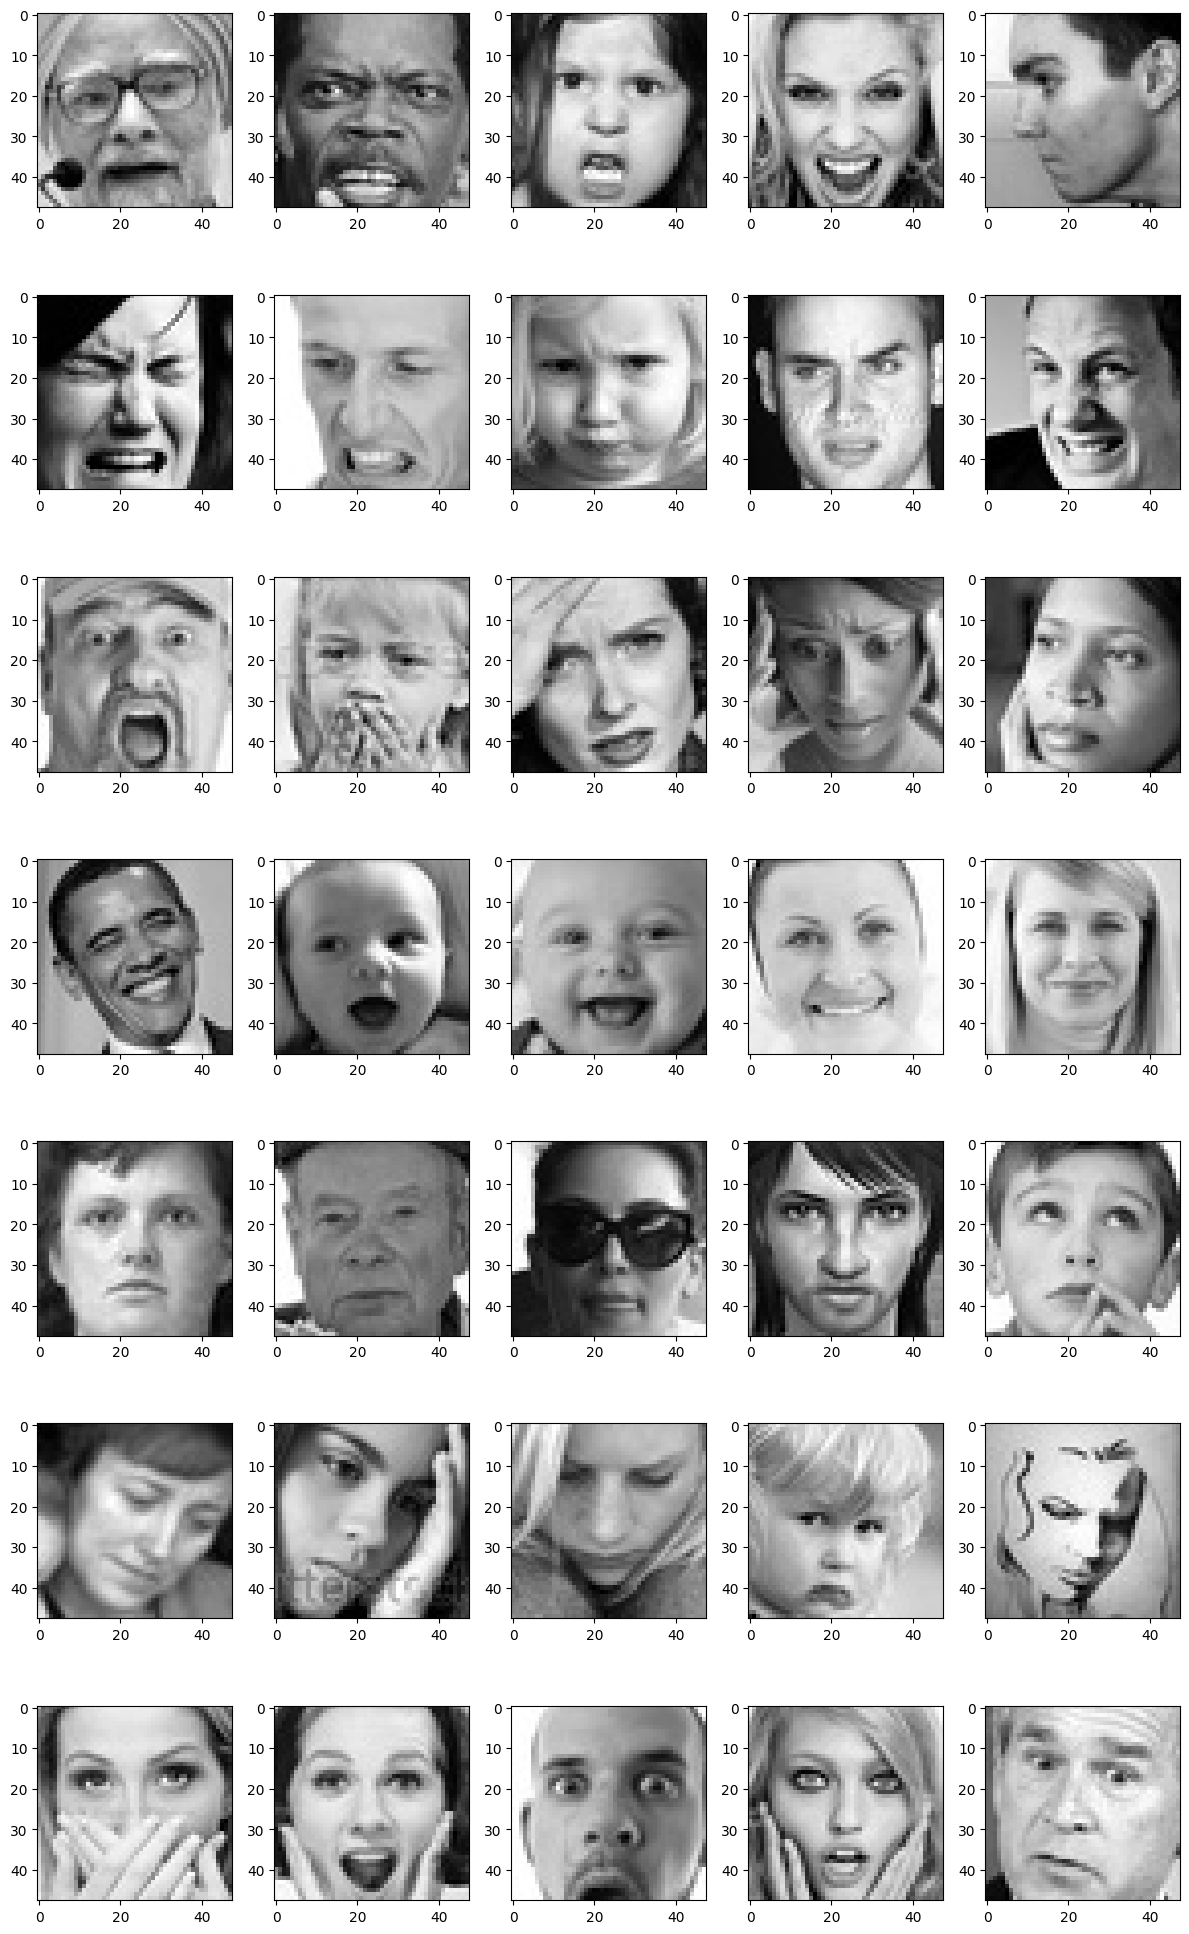

In [4]:
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
# from keras.preprocessing.image import load_img, img_to_array

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

img_path_train = '../datasets/train/'
img_path_validation = '../datasets/validation/'
plt.figure(0, figsize=(12,20))
pic_size = 48
cnt = 0
for expression in emotions:
    print(expression)
    for i in range(1,6):
        cnt = cnt + 1
        plt.subplot(7,5,cnt)
        img = Image.open(img_path_train + expression + '/' +os.listdir(img_path_train + expression)[i], 'r')
        plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()


In [5]:
# building data generator 

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128




train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(img_path_validation,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [16]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50

#Resnet Model Building
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


In [17]:
#Fine tuning parameters
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_7536\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


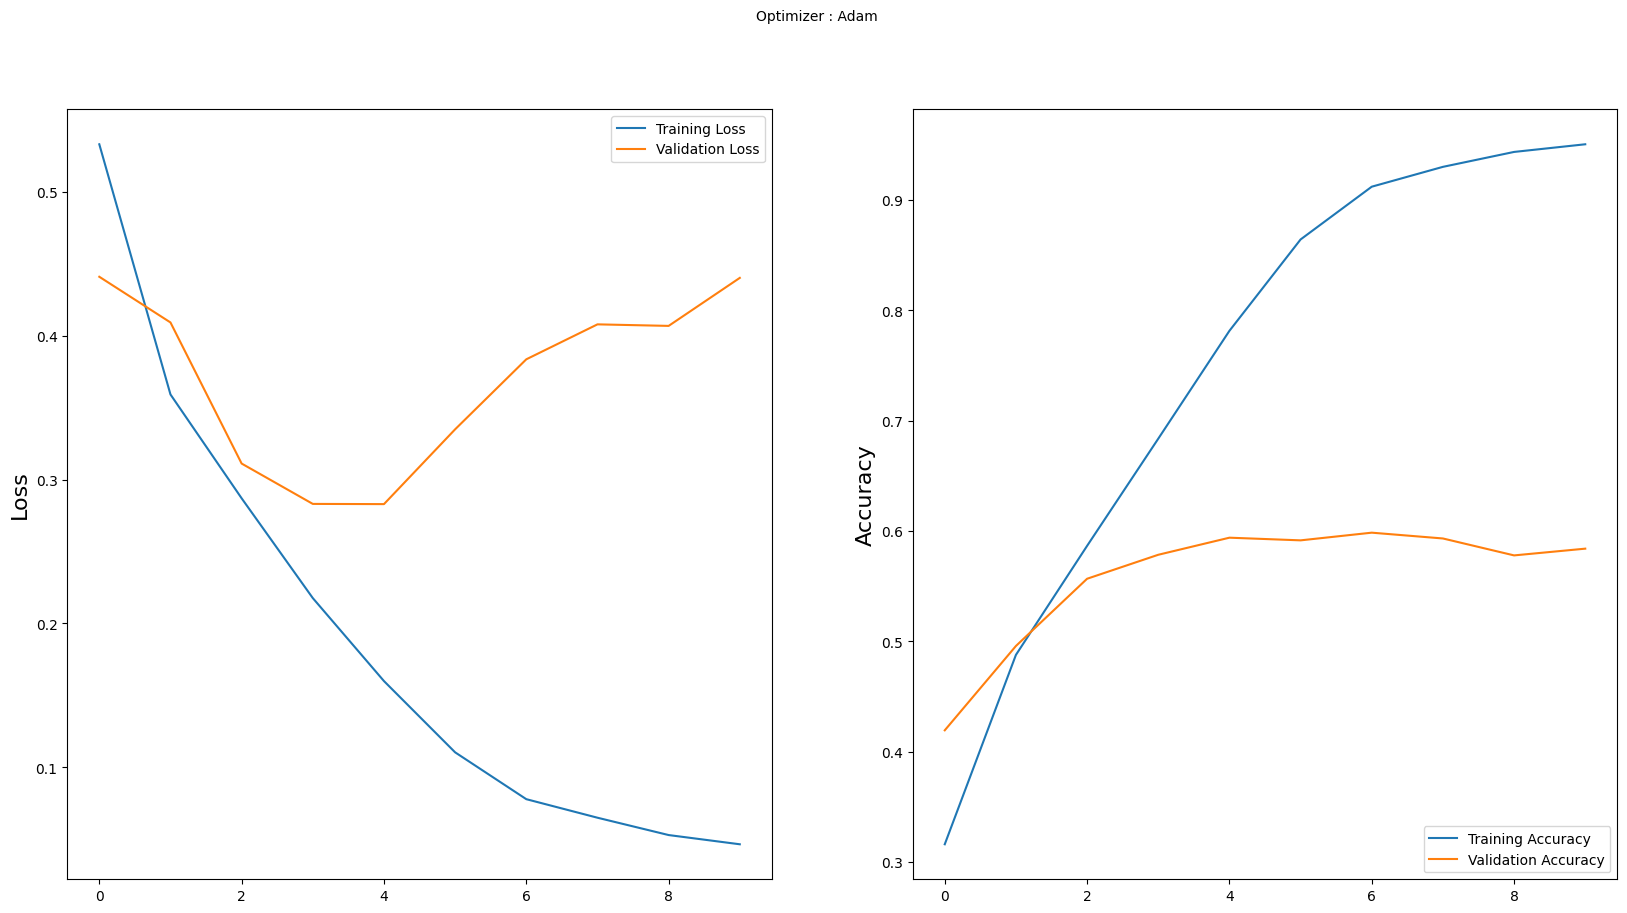

In [19]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Can see from the graph we have rising validation loss problem past epoch five at the learning rate of 0.0001.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
results = model.evaluate(train_generator)
preds   = model.predict(train_generator)
print('The Resnet50 achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

226/226 [==============================] - 13s 53ms/step
The Resnet50 achieved a categorical accuracy of 97.26%!


In [21]:
#Fine tuning parameters, increase learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_7536\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


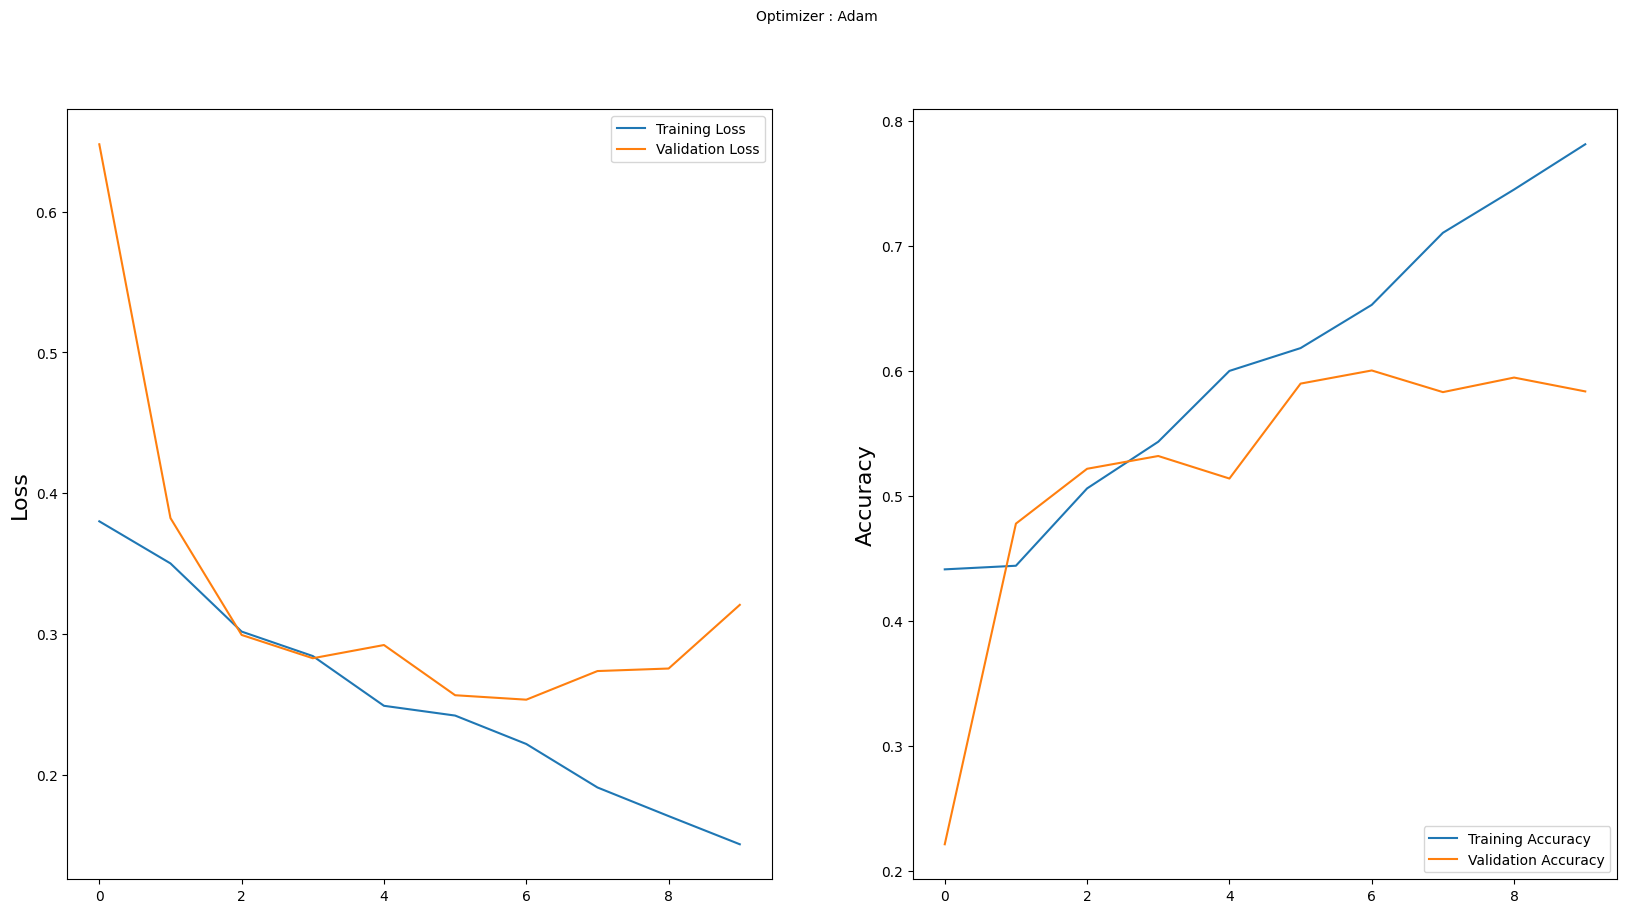

In [23]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

Can see from the above graphs that validation loss does not rise after epoch 5 when we use a slower learning rate.

In [24]:
#Fine tuning parameters, at same learning rate, try a different optimizer
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [25]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_7536\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


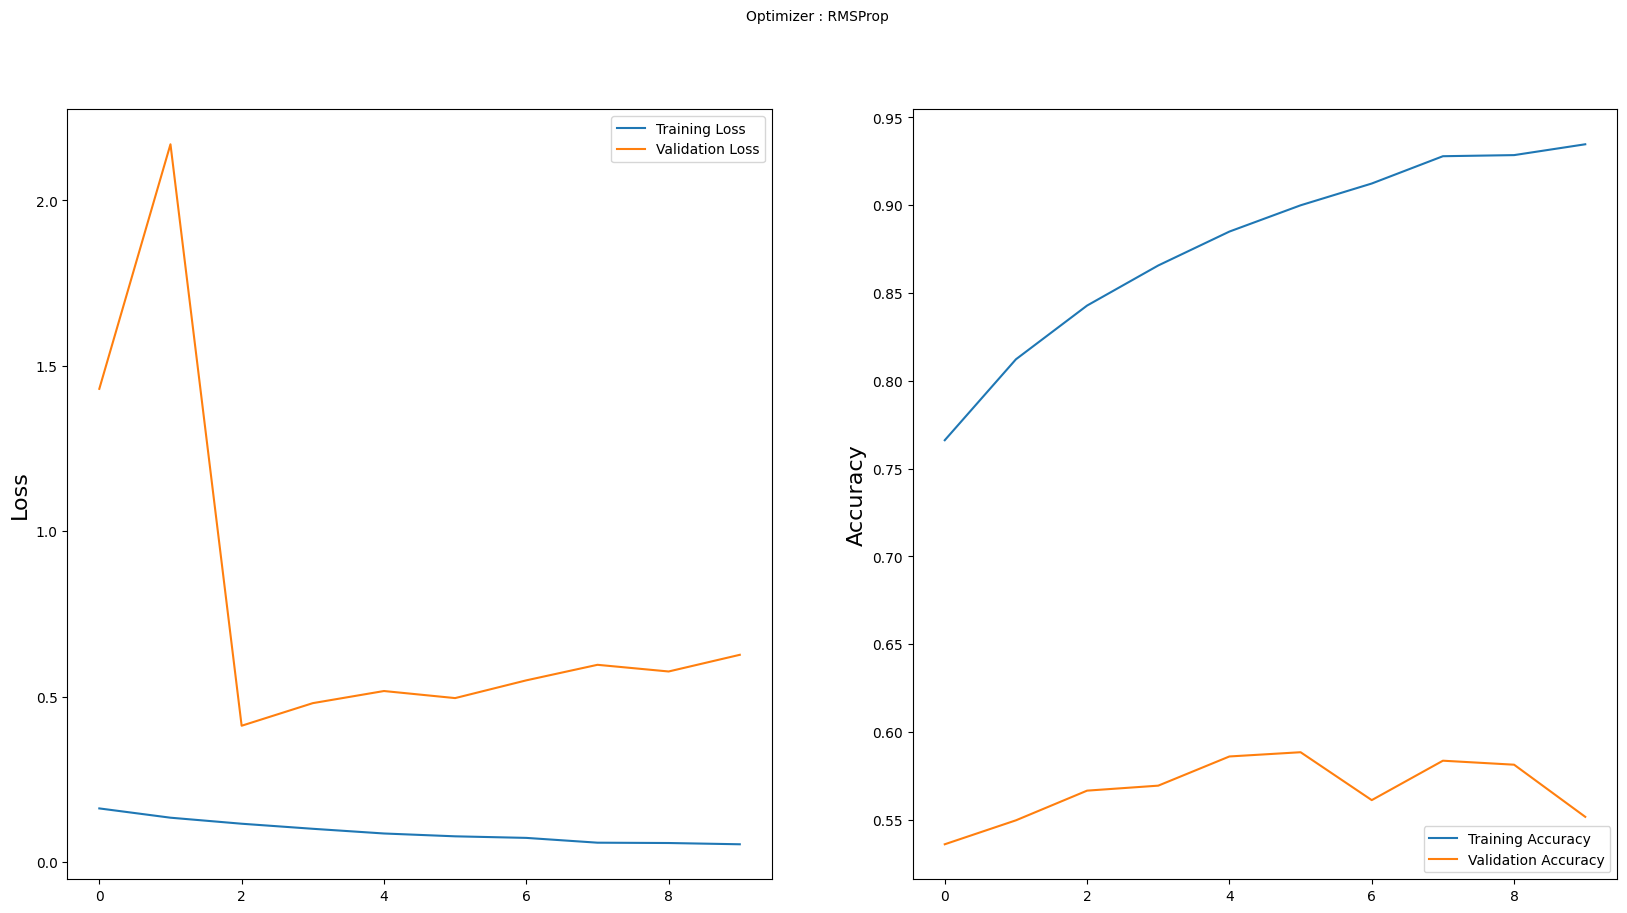

In [26]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSProp', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

RMSProp does not look too promising with a high possibility of overfitting issues, so we will try another optimizer.

In [27]:
#Fine tuning parameters, at same learning rate, try a different optimizer
from keras.optimizers import Nadam
model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [28]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_7536\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


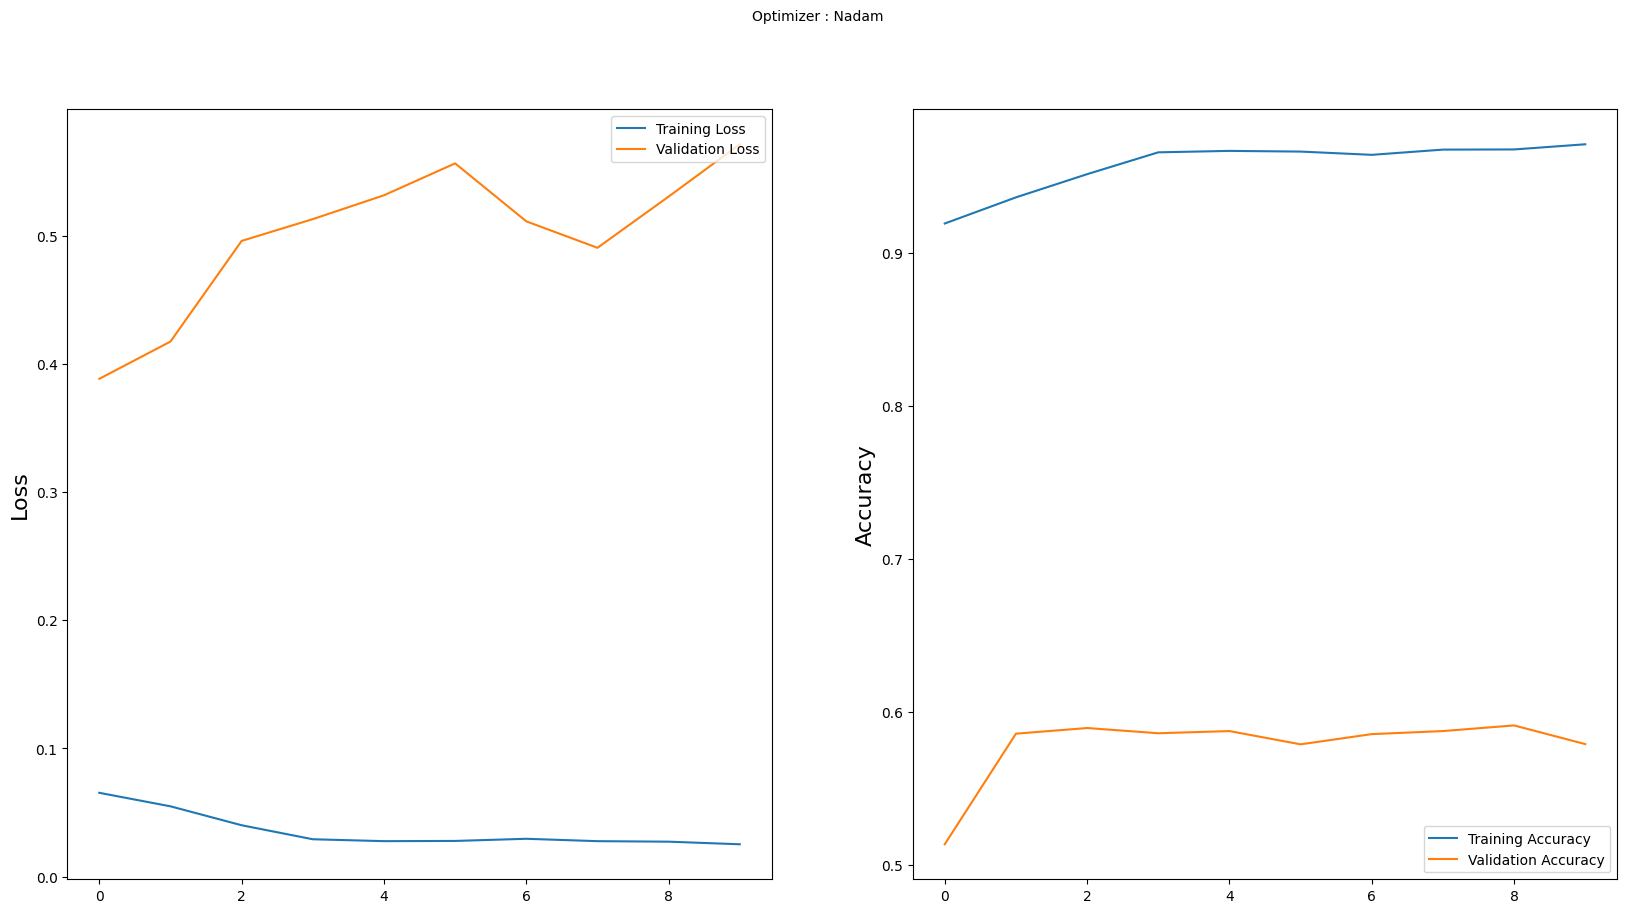

In [29]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Nadam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

Nadam seems to suffer from the overfitting issue as well, so Adam is still the best option we have for now.

In [6]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50, EfficientNetB4

#Resnet Model Building
model = Sequential()
model.add(EfficientNetB4(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


71686520/71686520 [==============================] - 8s 0us/step


In [7]:
#Fine tuning parameters, increase learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 2, 2, 1792)       17673823  
                                                                 
 global_max_pooling2d (Globa  (None, 1792)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 7)                 12551     
                                                                 
Total params: 17,686,374
Trainable params: 17,561,167
Non-trainable params: 125,207
_________________________________________________________________


In [8]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_19928\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


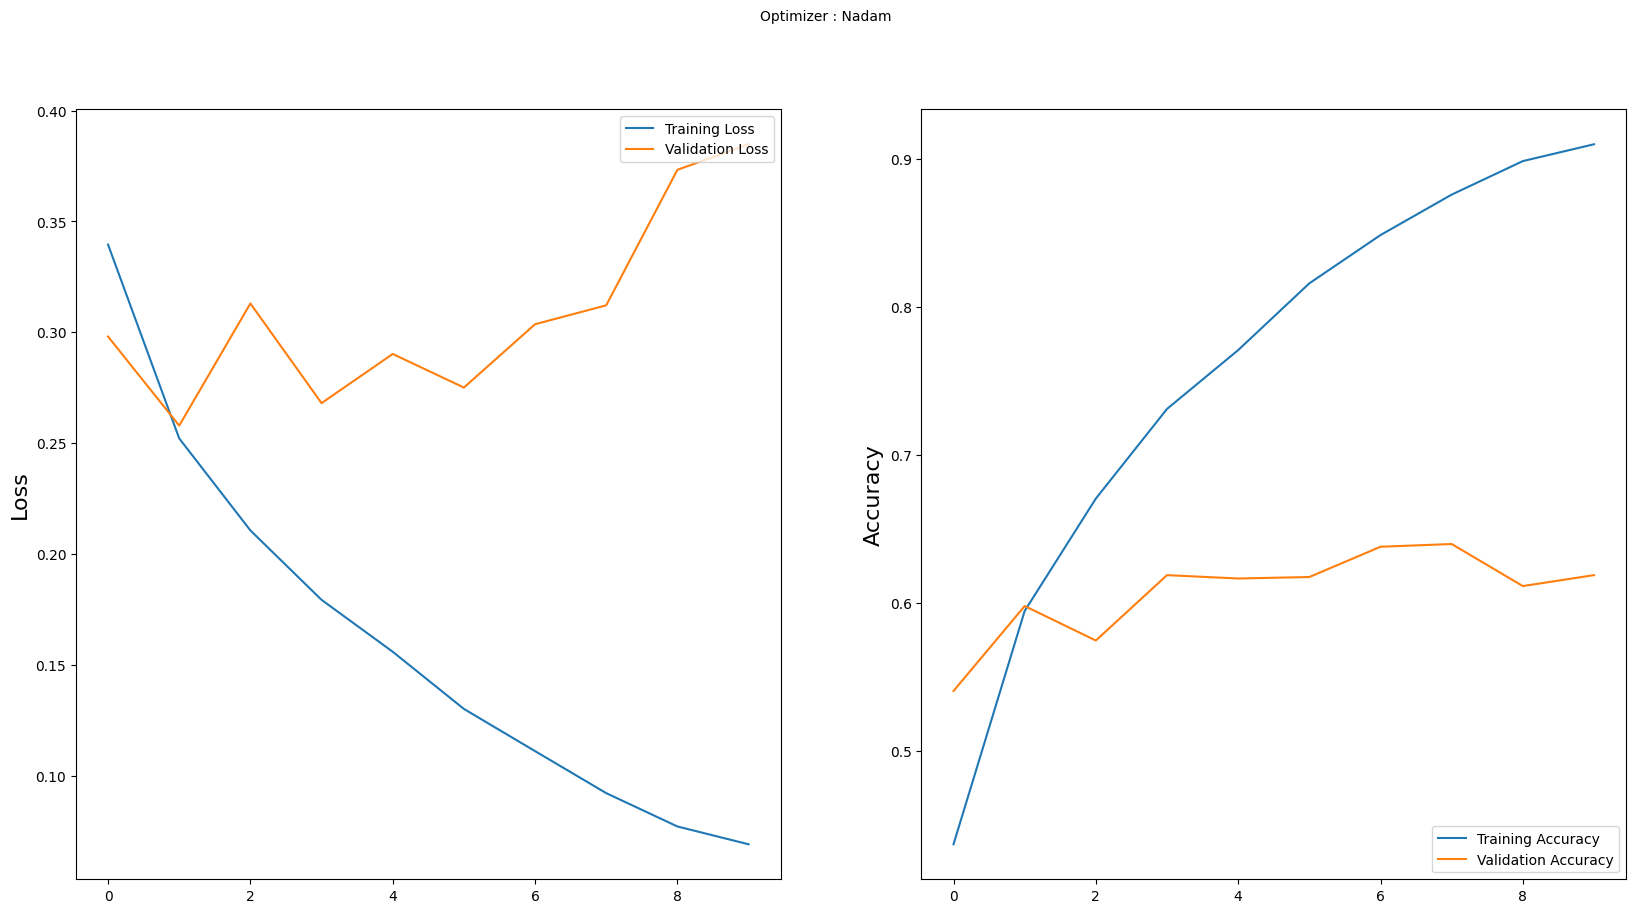

In [9]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Nadam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

In [14]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50

#Resnet Model Building
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


In [15]:
#Fine tuning parameters, increase learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
# number of epochs to train the NN
epochs = 20

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_19928\3153791020.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


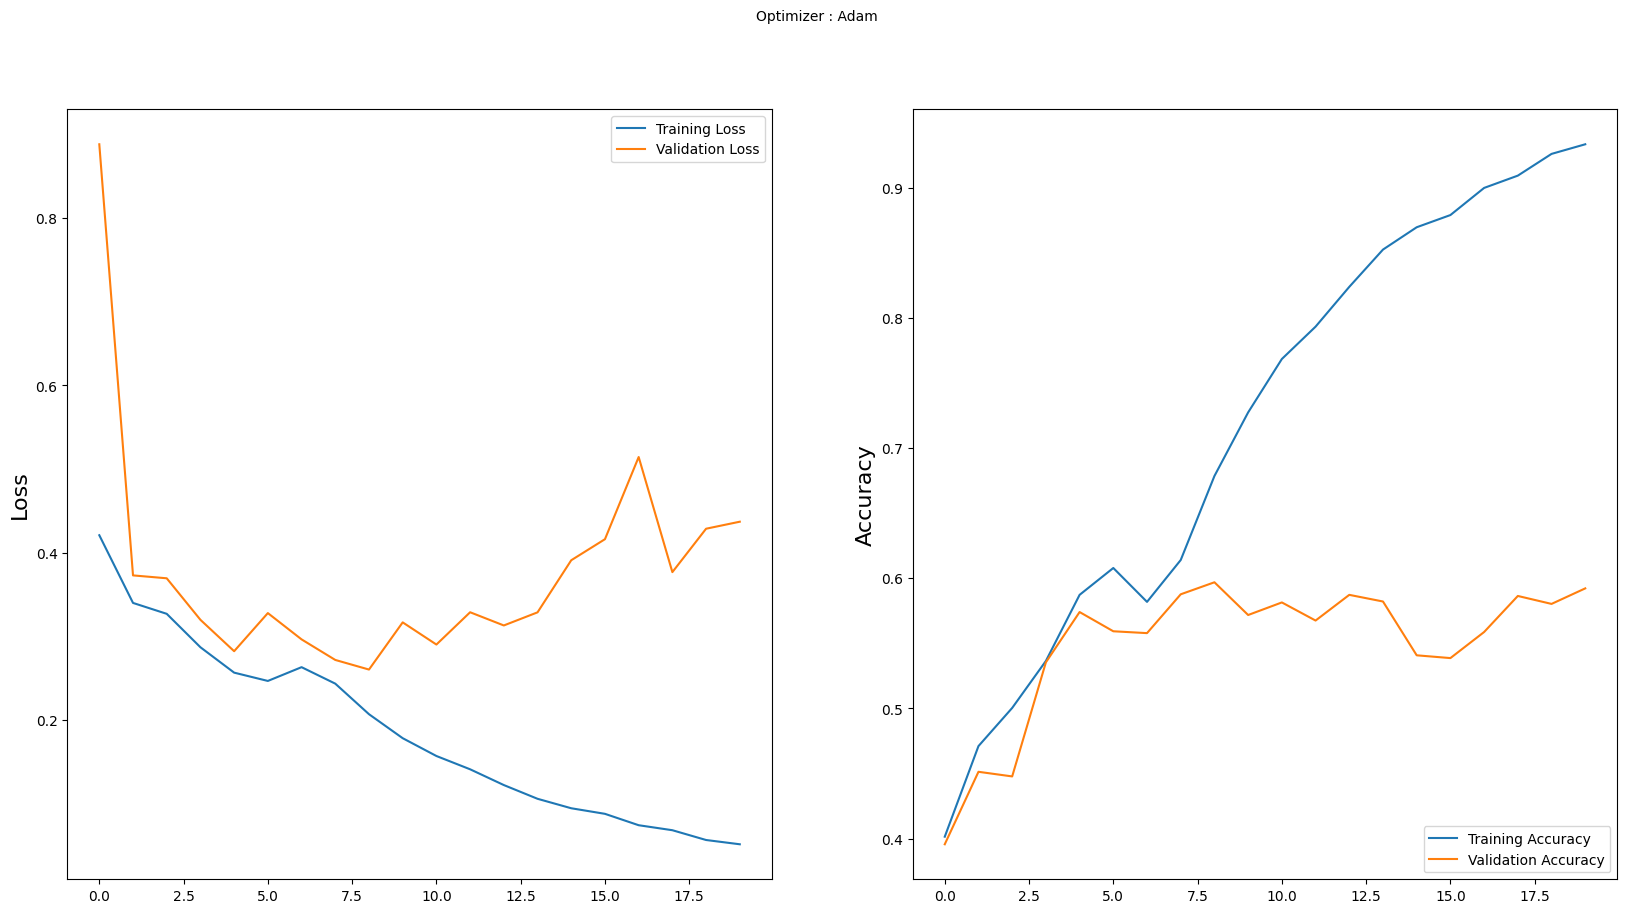

In [17]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')